<a href="https://colab.research.google.com/github/adharemna/Maximum-path-sum/blob/main/TP_L1_trend_filtering%2C_matrix_competion_and_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages to upload







In [1]:
from google.colab import drive
from google.colab import files
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy as scipy
import cvxopt as cvxopt
from numpy.linalg import matrix_rank
!pip install cvxpylayers
from cvxpylayers.torch import CvxpyLayer
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 7.9 MB/s eta 0:00:00


# Data

In this lab, the dataset used are the evolution of delays in a network of N nodes. The columns are the time instants and the row are the source-destination pairs.

1/ Upload the dataset and excute the cell with plt.plot. Can you list three main properties that your dataset have?

In [ ]:
uploaded = files.upload()
df=pd.read_csv('red_data1.csv', sep=',',dtype=float)
df=np.array(df.values)

Saving red_data1.csv to red_data1.csv


Text(0, 0.5, 'delay')

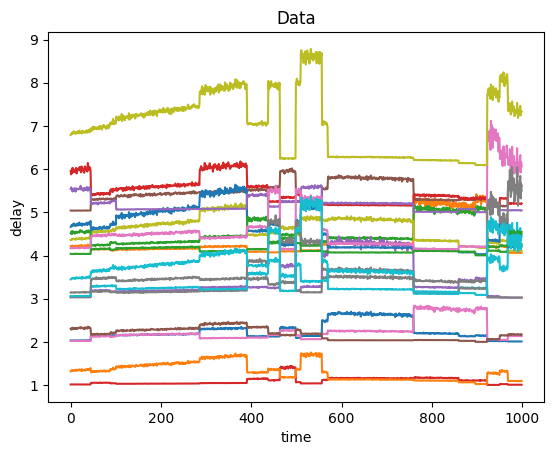

In [ ]:
plt.plot()
for i in range(df.shape[0]):
  plt.plot(df[i,:])
plt.title('Data')
plt.xlabel('time')
plt.ylabel('delay')

In this lab, we will focus on the matrix completion problem. The matrix completion aims to fill in missing entries of a partially observed matrix. In the next cell, we only sample 50% of the observations of the delay matrix.

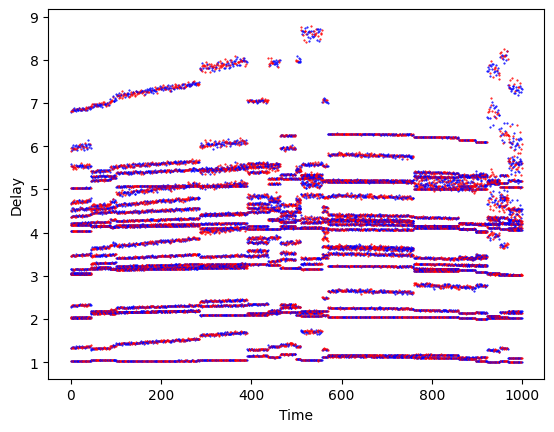

In [ ]:
m = df.shape[0]
n = df.shape[1]
W = np.random.binomial(n=1, p=0.5, size=m * n).reshape(m, n)

plt.plot()

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if W[i, j] == 1:
            plt.plot(j, df[i, j], marker='.', color='b',markersize=1)
        else:
            plt.plot(j, df[i, j], marker='.', color='r',markersize=1)

plt.xlabel('Time')
plt.ylabel('Delay')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker
from sklearn import datasets, manifold


def plot_2d(points, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points)
    plt.show()

def add_2d_scatter(ax, points, title=None):
    x, y = points.T
    ax.scatter(x, y, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())




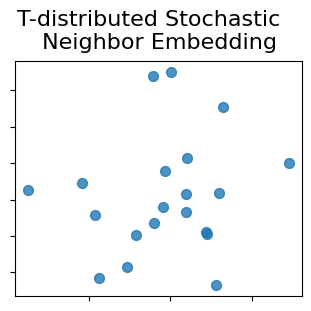

[[ -9.2301235   -2.1716888 ]
 [  1.963848     0.782351  ]
 [ -0.958868    -1.0589294 ]
 [  5.633079   -11.7902975 ]
 [ -2.0359173   -3.2584746 ]
 [ 14.555563     5.03153   ]
 [  1.9624376   -1.6516758 ]
 [  5.9587746    0.8468642 ]
 [ -5.3300395   -9.276932  ]
 [  4.382943    -4.3933387 ]
 [  6.5053587   12.68767   ]
 [-10.841574     2.265088  ]
 [  2.0780158    5.6971436 ]
 [  0.10441297  17.572302  ]
 [ -4.1739426   -4.9291544 ]
 [ -8.740085   -10.7419615 ]
 [ -0.6929781    3.8624973 ]
 [-17.544237     1.287754  ]
 [ -2.1172109   16.935001  ]
 [  4.5100803   -4.710395  ]]


In [ ]:
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=5,
    init="random",
    n_iter=250,
    random_state=0,
)
S_t_sne = t_sne.fit_transform(df)
plot_2d(S_t_sne, "T-distributed Stochastic  \n Neighbor Embedding")
print(S_t_sne)

# Completion using matrix factorisation


The matrix completion can be solved as follows:

 Let $M$ be the partially observed matrix of size $m \times n$, and $W$ be the set of observed indices (entries). We seek to find matrices $U$ and $V$ such that $M \approx UV$, where $U$ is of size $m \times r$, $V$ is of size $r \times n$ with rank $r< m, n$. Usually to find $U$ and $V$ we solve the following optimisation problem:
$$
\min_{U, V} \sum_{(i, j) \in \Omega} (M_{ij} - (UV)_{ij})^2
$$

To solve such problems, one classical algorithm is  the Alternating Least Squares (ALS) algorithm :

- Initialize $U^{(0)}$ and $V^{(0)}$ with small random values.
- Repeat until convergence:
  * Update $U$ by solving by minimizing the following objective while fixing $V$: $$U = \arg\min_{U} \sum_{i,j: W_{ij}=1} (M_{ij} - (U V)_{ij})^2$$
  * Update $V$ by solving by minimizing the following objective while fixing $U$: $$V = \arg\min_{U} \sum_{i,j: W_{ij}=1} (M_{ij} - (U V)_{ij})^2$$


2/ Complete the code below to implement the Alternating Least Squares (ALS) algorithm? You will need to use the cvxpy package. Try to observe the performance of the reconstruction when you change the number of points observed.

In [ ]:
# SVD
np.random.seed(1)
# Ensure same initial random Y, rather than generate new one
# when executing this cell.


A = df[:,:300]
m = A.shape[0]
n = A.shape[1]
k = 5
W = np.random.binomial(n=1, p=0.5, size=m*n).reshape(m,n)#np.random.randint(0,2, size=(m,n))
# Initialize Y randomly.
U_init = np.random.rand(m, k)

U = U_init

# Perform alternating minimization.
MAX_ITERS = 15
residual = np.zeros(MAX_ITERS)
for iter_num in range(1, 1+MAX_ITERS):
    # At the beginning of an iteration, X and Y are NumPy
    #  array types, NOT CVXPY variables.

    # For odd iterations, treat Y constant, optimize over X.
    if iter_num % 2 == 1:
        V = # use cp.Variable
    # For even iterations, treat X constant, optimize over Y.
    else:
        U = ## use cp.Variable

    # Solve the problem
    C = U@V
    cost = 0
    for i in range(m):
      for j in range(n):
        if W[i,j] ==1:
          cost = cost + # complete with the loss in i,j
    obj = cp.Minimize(cost)
    prob = cp.Problem(obj)
    prob.solve(solver=cp.SCS, max_iters=10000)

    if prob.status != cp.OPTIMAL:
        raise Exception("Solver did not converge!")

    print('Iteration {}, residual norm {}'.format(iter_num, prob.value))
    residual[iter_num-1] = prob.value

    # Convert variable to NumPy array constant for next iteration.
    if iter_num % 2 == 1:
        V = V.value
    else:
        U = U.value

In [ ]:
times_series = np.matmul(U,V)
plt.plot()
for i in range(times_series.shape[0]):
  plt.plot(A[i,:],color = "blue")
  plt.plot(times_series[i,:],'--', color = "red",linewidth=2)


plt.title('Reconstruction')
plt.xlabel('time')
plt.ylabel('delay')

3/ One main property of delays is that they are positive. How to modify the ALS to ensure positiveness? Implement your solution and try it on the dataset with different sampling rate.

# Neural Network

We will now do the completion of one time-serie.

In [ ]:
y_df = df[0,:400]
plt.plot()
plt.plot(y_df)
plt.title('Data')
plt.xlabel('time')
plt.ylabel('delay')

4/ You will find below the code of the creation and the training of a neural network dedicated to completion. Comment the code and describe what is the input of the neural network. Comment about the performance of the network. What do you suggest to improve its performance?

Epoch [10/100], Loss: 0.0013
Epoch [20/100], Loss: 0.0012
Epoch [30/100], Loss: 0.0024
Epoch [40/100], Loss: 0.0070
Epoch [50/100], Loss: 0.0007
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0030
Epoch [90/100], Loss: 0.0008
Epoch [100/100], Loss: 0.0009


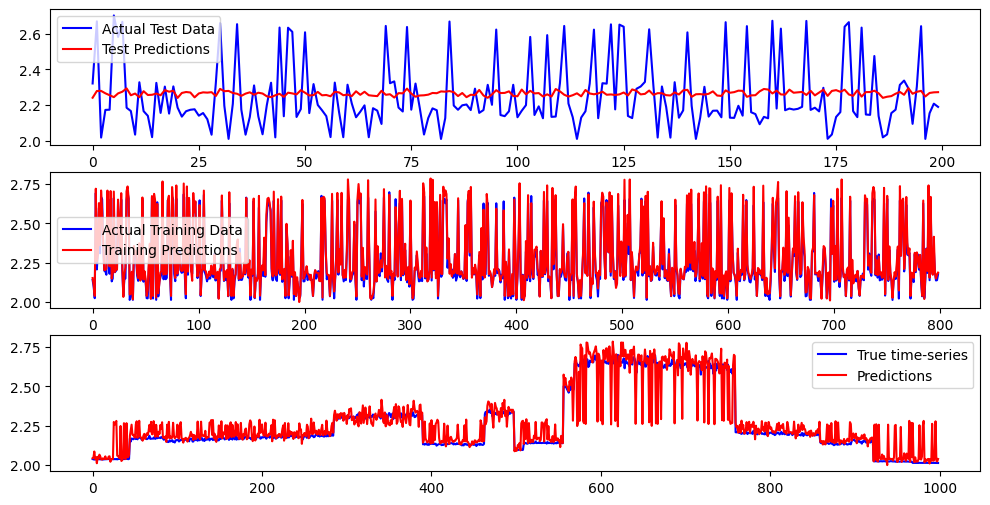

In [ ]:

# Hyperparameters
input_size =len(y_df)-1
output_size = 1
hidden_size = 300
num_epochs = 100
learning_rate = 0.01
weight_decay = 0

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fch1 = nn.Linear(hidden_size, hidden_size)
        self.fch2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fch1(out)
        out = self.relu(out)
        out = self.fch2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

X = np.eye(len(y_df) - 1)
y = y_df[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).view(-1, 1)
y_test = torch.FloatTensor(y_test).view(-1, 1)

batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Training the model
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the original data and model predictions on the test set
model.eval()
with torch.no_grad():
    predictions_test = model(X_test)
    predictions_train = model(X_train)
    predictions_all = model(torch.FloatTensor(X))


# Plot the original data and model predictions on the test set
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(y_test.numpy(), label='Actual Test Data', color='blue')
plt.plot(predictions_test.numpy(), label='Test Predictions', color='red')
plt.legend()

# Plot the original data and model predictions on the training set
plt.subplot(3, 1, 2)
plt.plot(y_train.numpy(), label='Actual Training Data', color='blue')
plt.plot(predictions_train.numpy(), label='Training Predictions', color='red')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(y, label='True time-series', color='blue')
plt.plot(predictions_all.numpy(), label='Predictions', color='red')
plt.legend()
plt.show()



The second property of a delay time-serie is that it is piecewise stationnary. We will see now how to enforce this property in the neural network using  Total Variation (TV) regularization. TV is a technique commonly used in image processing and signal denoising.  It's designed to preserve edges and reduce noise by penalizing the total variation or total change in the values of a signal. In the context of time-series data, such as in your neural network, applying TV regularization can help in smoothing the temporal variations while preserving important features.

5/ Use the [following code](https://www.cvxpy.org/examples/applications/l1_trend_filter.html) to filter your time-series when everything is observed. What do you observe when you modify vlambda ?

6/ Use the following code to smooth the prediction of the neural network. What are the performance of this new approach.

7/ The code below is more efficient way of using total variation penalisation. Comment and explain the code. Compare with the performance of the different approaches.

In [ ]:
# Parameters



D_in = input_size
e = np.ones((1, D_in))
D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), D_in-2, D_in)
lambd_ = 10
# Variables and Parameter cp
x = cp.Variable(D_in)
input = cp.Parameter(D_in)
input_model = cp.Parameter(D_in)


# Solve l1 trend filtering problem.
obj = cp.Minimize(0.5 * cp.sum_squares(input - x)+ lambd_ * cp.norm(D@x, 1) )
prob = cp.Problem(obj)
TV_layer_prox = CvxpyLayer(prob, [input], [x])

In [ ]:
# Generate synthetic time series data
# Replace this with your own dataset or data loading code

# Hyperparameters
output_size = 1  # Dimension of output data (predicted value)
hidden_size = 300  # Number of neurons in the hidden layer
num_epochs = 20
learning_rate = 0.01
weight_decay = 0
lambd_1 = 0.1

# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.mask = nn.Linear(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fch1 = nn.Linear(hidden_size, hidden_size)
        self.fch2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.mask(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fch1(out)
        out = self.relu(out)
        out = self.fch2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Create the model
model = SimpleNN()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Generate synthetic time series data

# Split the data into input (X) and output (y)
X = np.eye(input_size)  # One-hot encoding for time instant
y = y_df[:input_size]

# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).view(-1, 1)
y_test = torch.FloatTensor(y_test).view(-1, 1)

# Data loader for training data
batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Training the model
y_filter = torch.rand(input_size)
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss_1 = criterion(outputs, targets)
        loss_2 = criterion(y_filter,  model(torch.FloatTensor(X)).view(-1))
        loss = loss_1 + loss_2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        outputs = model(torch.FloatTensor(X))
        y_filter = TV_layer_prox(outputs.view(-1))[0]

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the original data and model predictions on the test set


In [ ]:
model.eval()
with torch.no_grad():
    predictions_test = model(X_test)
    predictions_train = model(X_train)
    predictions_all = model(torch.FloatTensor(X))


# Plot the original data and model predictions on the test set
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(y_test.numpy(), label='Actual Test Data', color='blue')
plt.plot(predictions_test.numpy(), label='Test Predictions', color='red')
plt.legend()

# Plot the original data and model predictions on the training set
plt.subplot(3, 1, 2)
plt.plot(y_train.numpy(), label='Actual Training Data', color='blue')
plt.plot(predictions_train.numpy(), label='Training Predictions', color='red')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(y, label='True time-series', color='blue')
plt.plot(predictions_all.numpy(), label='Predictions', color='red')
plt.legend()
plt.show()

